In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopy
import requests
from time import sleep
from random import randint
import geopandas as gpd
from shapely.geometry import Point
import datetime
import branca.colormap as cm
import time
import datetime
import gdal
import seaborn as sns

derecho911_df = pd.read_csv('../data/911_Phone Calls_Derecho_050320 050420.csv')
tornado911_df = pd.read_csv('../data/911_Phone_Calls_Tornado_030320.csv')
derecho_incidents_df = pd.read_csv('../data/Computer Aided Dispatch Data_Derecho Incidents 050320-050420.csv', skiprows=3)
tornado_incidents_df = pd.read_csv('../data/Computer Aided Dispatch Data_Tornado Incidents 030320.csv', skiprows=3)
single_family_housing_df = pd.read_csv('../data/2017 single family_final_with_sqft.txt')

In [310]:
## Filter to get the derech911 dataframe with only ALI NaNs ##
derech_nans = derecho911_df['ALI Latitude'].isna()
derecho911_nans_df = derecho911_df[derech_nans]
tower_not_nans = derecho911_nans_df['Cell Tower Address'].notna()
derecho911_tower_not_lat = derecho911_nans_df[tower_not_nans]
derecho911_full_filter = derecho911_tower_not_lat['Cell Tower Address'] != 'WIRELESS CALLER'
derecho911_fully_filtered = derecho911_tower_not_lat[derecho911_full_filter]

In [311]:
torn_nans = tornado911_df['ALI Latitude'].isna()
tornado911_nans_df = tornado911_df[torn_nans]
torn_tower_not_nans = tornado911_nans_df['Cell Tower Address'].notna()
tornado911_tower_not_lat = tornado911_nans_df[torn_tower_not_nans]

In [312]:
## TEST ANY INDIVIDUAL ADDRESS ##
test_address = '5655 FRIST BLVD'
HOST = 'https://nominatim.openstreetmap.org/search?q=' + test_address + ',Nashville,Tennessee&format=json&polygon=1&addressdetails=1'

In [313]:
test_latlong = '742 Rowan Drive,Nashville,Tennessee'
HOST1 = 'https://nominatim.openstreetmap.org/search?q=' + test_latlong + '&format=json&polygon=1&addressdetails=1'
req = requests.get(HOST1)
req.text

'[{"place_id":266428967,"licence":"Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright","osm_type":"way","osm_id":19459937,"boundingbox":["36.219591128471","36.219691128471","-86.816404397731","-86.816304397731"],"lat":"36.21964112847117","lon":"-86.81635439773072","display_name":"742, Rowan Drive, Buena Vista Estates, Nashville-Davidson, Davidson County, Tennessee, 37207, United States of America","class":"place","type":"house","importance":0.5209999999999999,"address":{"house_number":"742","road":"Rowan Drive","hamlet":"Buena Vista Estates","city":"Nashville-Davidson","county":"Davidson County","state":"Tennessee","postcode":"37207","country":"United States of America","country_code":"us"}}]'

In [314]:
def location_retrieve(addresses_in_nash):  ##A list of two-tuples (index, Cell Tower Address)
    locations = {}
    for ind, address in addresses_in_nash:
        piked_address = address.replace('PKE', 'PIKE', 1)
        HOST = 'https://nominatim.openstreetmap.org/search?q='
        HOST = HOST + piked_address
        HOST = HOST + ',Tennessee&format=json&polygon=1&addressdetails=1'
        req = requests.get(HOST)
        req_dict = req.json()        
        if len(req_dict) > 0:
            ##print(str(req_dict_list))
            result_dict = {}
            result_dict['zip'] = req_dict[0]['address']['postcode']
            if 'city' in req_dict[0]['address']:                
                result_dict['city'] = req_dict[0]['address']['city']
            elif 'village' in req_dict[0]['address']:
                result_dict['city'] = req_dict[0]['address']['village']
            else:
                result_dict['city'] = req_dict[0]['address']['hamlet']
            if 'neighbourhood' in req_dict[0]['address']:
                result_dict['hood'] = req_dict[0]['address']['neighbourhood']
            else:
                result_dict['hood'] = np.nan
            result_dict['lat'] = req_dict[0]['lat']
            result_dict['lon'] = req_dict[0]['lon']
            locations[ind] = result_dict
        else:
            locations[ind] = {'zip': 0, 'city': '', 'lat': 0.0, 'lon': 0.0}
        sleep(randint(1,4))
    return locations

#### TEST function using sample data ####
some_addresses = [(5,'5600 OBRIEN AV'), (82, '4220 HARDING PKE')]

locations = location_retrieve(some_addresses)
print(str(locations))

{5: {'zip': '37209', 'city': 'Nashville-Davidson', 'hood': 'West Nashville', 'lat': '36.1498707', 'lon': '-86.8653'}, 82: {'zip': '37205', 'city': 'Nashville-Davidson', 'hood': nan, 'lat': '36.1296963', 'lon': '-86.84464522914443'}}


In [315]:
## Create Test DataFrame ##
data = {'Seizure DateTime':['5/3/2020 18:22', '5/3/2020 18:22'],
        'CallTypeId': ['911 Calls', '911 Calls'], 'ALI Latitude': [np.nan, np.nan], 
        'ALI Longitude': [np.nan, np.nan], 'Cell Tower Address': ['5600 OBRIEN AV', '4220 HARDING PKE'], 'zip': ['37207', 37209]}
test_nan_df = pd.DataFrame(data, index=[5, 82])
##print(test_nan_df.head())

In [316]:
def integrate_latlon(nan_df, df, address_col, lat_col, lon_col):  ## input dataframe and the string values for the column names
    loc = location_retrieve(zip(nan_df.index, nan_df[address_col]))
    for ind in loc:
        df.at[ind, lat_col] = loc[ind]['lat']
        df.at[ind, lon_col] = loc[ind]['lon']
    return df

##TEST##
integrated = integrate_latlon(test_nan_df, test_nan_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')
##integrated.head()

In [317]:
##Initially used to test before the integrate_latlon function was written
##retrievals = location_retrieve(zip(derecho911_fully_filtered.index, derecho911_fully_filtered['Cell Tower Address']))

derecho911_fill_df = integrate_latlon(derecho911_fully_filtered, derecho911_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')


In [318]:
tornado911_fill_df = integrate_latlon(tornado911_tower_not_lat, tornado911_df, 'Cell Tower Address', 'ALI Latitude', 'ALI Longitude')

In [319]:
zipcodes = gpd.read_file('../data/zipcodes.geojson')
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]

##Make a geometry column which contains points required for spatial join
derecho911_fill_df['geometry'] = derecho911_fill_df.apply(lambda row: Point(row['ALI Longitude'], row['ALI Latitude']), axis=1)
tornado911_fill_df['geometry'] = tornado911_fill_df.apply(lambda row: Point(row['ALI Longitude'], row['ALI Latitude']), axis=1)

##Make a latLong column which contains an array which is required for map markers for folium
derecho911_fill_df['latlong'] = derecho911_fill_df.apply(lambda row: [row['ALI Latitude'], row['ALI Longitude']], axis=1)
tornado911_fill_df['latlong'] = tornado911_fill_df.apply(lambda row: [row['ALI Latitude'], row['ALI Longitude']], axis=1)

tornado_incidents_df['geometry'] = tornado_incidents_df.apply(lambda row: Point(row['Longitude1'], row['Latitude1']), axis=1)
derecho_incidents_df['geometry'] = derecho_incidents_df.apply(lambda row: Point(row['Longitude1'], row['Latitude1']), axis=1)

tornado_incidents_df['latlong'] = tornado_incidents_df.apply(lambda row: [row['Latitude1'], row['Longitude1']], axis=1)
derecho_incidents_df['latlong'] = derecho_incidents_df.apply(lambda row: [row['Latitude1'], row['Longitude1']], axis=1)

t911_zips_geo = gpd.GeoDataFrame(tornado911_fill_df, 
                           crs = zipcodes.crs, 
                           geometry = tornado911_fill_df['geometry'])
t911_zips_gpd = gpd.sjoin(t911_zips_geo, zipcodes, op = 'within')

d911_zips_geo = gpd.GeoDataFrame(derecho911_fill_df, 
                           crs = zipcodes.crs, 
                           geometry = derecho911_fill_df['geometry'])
d911_zips_gpd = gpd.sjoin(d911_zips_geo, zipcodes, op = 'within')

tincidents_zips_geo = gpd.GeoDataFrame(tornado_incidents_df, 
                        crs = zipcodes.crs, 
                        geometry = tornado_incidents_df['geometry'])
tincidents_zips_gpd = gpd.sjoin(tincidents_zips_geo, zipcodes, op = 'within')

dincidents_zips_geo = gpd.GeoDataFrame(derecho_incidents_df, 
                        crs = zipcodes.crs, 
                        geometry = derecho_incidents_df['geometry'])
dincidents_zips_gpd = gpd.sjoin(dincidents_zips_geo, zipcodes, op = 'within')

##simple map example following Mary's intro to geo
##ax = zipcodes.plot(figsize = (8, 10), color = 'lightgreen')
##t911_geo.plot( ax = ax);
##plt.show();

In [320]:
##Try same with tiger shapefiles from US GOV - TN tract level
tract_shapes = gpd.read_file('../data/tl_2019_47_tract.shp')

d_inc_tracts_geo = gpd.GeoDataFrame(derecho_incidents_df, 
                           crs = tract_shapes.crs, 
                           geometry = derecho_incidents_df['geometry'])
d_incidents_tracts_gpd = gpd.sjoin(d_inc_tracts_geo, tract_shapes, how='right', op = 'within')
d_incidents_tracts_gpd = d_incidents_tracts_gpd[d_incidents_tracts_gpd['latlong'].notna()]

In [321]:
d911_geo = gpd.GeoDataFrame(derecho911_fill_df, 
                           crs = tract_shapes.crs, 
                           geometry = derecho911_fill_df['geometry'])

d_911_tracts_gpd = gpd.sjoin(d911_geo, tract_shapes, how='right', op = 'within')
d_911_tracts_gpd = d_911_tracts_gpd[d_911_tracts_gpd['latlong'].notna()]

In [322]:
census_url = 'https://api.census.gov/data'
year = '2018'
dataset = 'acs/acs5'
base_url = '/'.join([census_url, year, dataset])
get_tract_vars = ['B01003_001E']
get_tract_vars = ["NAME"] + get_tract_vars
predicates = {}
predicates['get'] = ','.join(get_tract_vars)
predicates['for'] = 'tract:*'  ## Census tracts
predicates['in']  = 'state:47'  ## State of Tennessee

request = requests.get(base_url, params=predicates)
col_names = ['NAME', 'Total', 'state', 'county', 'tract']
census_df = pd.DataFrame(columns=col_names, data=request.json()[1:])
census_df = census_df[census_df['county'] == '037']
census_df['GEOID'] = census_df['state'] + census_df['county'] + census_df['tract']
census_df = census_df.drop(['NAME'], axis=1)
census_df = census_df.dropna()
census_df['Total'] = census_df['Total'].astype('int')  ## Make numeric cols numeric

## USE IF PULLING IN ADDITIONAL CENSUS DATA THAT NEEDS TO BE TRANSLATED TO PERCENT##
##col_names_core = ["Owner Occupied", "Renter Occupied"]
##for col in col_names_core:
##    census_df["Pct_" + col] = 100 * census_df[col] / census_df["Total"]



##Merge Population data and count number per area into new frame
merged_d_inc_tracts = pd.merge(census_df, d_incidents_tracts_gpd, on='GEOID')  ## Merge Population data with Incidents
grp_count_d_inc_tracts = merged_d_inc_tracts.groupby('tract')['tract'].count().to_frame()
grp_count_d_inc_tracts.rename(columns={'tract': 'incident_count'}, inplace=True)

merged_d_911_tracts = pd.merge(census_df, d_911_tracts_gpd, on='GEOID')  ## Merge Population data with Calls
grp_count_d_911_tracts = merged_d_911_tracts.groupby('tract')['tract'].count().to_frame()
grp_count_d_911_tracts.rename(columns={'tract': 'incident_count'}, inplace=True)

##Merge counts per tract back into main df // recalc area to acres // recalc mapped column to count per pop density (# / area / population)
d_inc_merged_w_cnt = pd.merge(grp_count_d_inc_tracts, merged_d_inc_tracts, left_index=True, right_on='tract' )
d_inc_merged_w_cnt['area_acres'] = d_inc_merged_w_cnt['ALAND'] / 43560.04
d_inc_merged_w_cnt['incidents_per_sqft'] = d_inc_merged_w_cnt['incident_count'] / d_inc_merged_w_cnt['area_acres'].astype('float64')
d_inc_merged_w_cnt['incidents_per_sqft_per_pop'] = d_inc_merged_w_cnt['incidents_per_sqft'] / d_inc_merged_w_cnt['Total'].astype('float64').replace({0: np.inf})

d_911_merged_w_cnt = pd.merge(grp_count_d_911_tracts, merged_d_911_tracts, left_index=True, right_on='tract' )
d_911_merged_w_cnt['area_acres'] = d_911_merged_w_cnt['ALAND'] / 43560.04
d_911_merged_w_cnt['incidents_per_sqft'] = d_911_merged_w_cnt['incident_count'] / d_911_merged_w_cnt['area_acres'].astype('float64')
d_911_merged_w_cnt['incidents_per_sqft_per_pop'] = d_911_merged_w_cnt['incidents_per_sqft'] / d_911_merged_w_cnt['Total'].astype('float64').replace({0: np.inf})

d_inc_merged_w_cnt = d_inc_merged_w_cnt.loc[d_inc_merged_w_cnt['Total'] >= 1000] ## Remove outliers
d_inc_merged_w_cnt = d_inc_merged_w_cnt[d_inc_merged_w_cnt['incidents_per_sqft_per_pop'] != 0.0]
d_inc_merged_w_cnt = d_inc_merged_w_cnt.drop_duplicates(subset=['tract'])  ##remove duplicate rows
d_inc_merged_w_cnt = gpd.GeoDataFrame(d_inc_merged_w_cnt)  ##Make it back into a geodataframe

d_911_merged_w_cnt = d_911_merged_w_cnt.loc[d_911_merged_w_cnt['Total'] >= 1000] ## Remove outliers
d_911_merged_w_cnt = d_911_merged_w_cnt[d_911_merged_w_cnt['incidents_per_sqft_per_pop'] != 0.0]
d_911_merged_w_cnt = d_911_merged_w_cnt.drop_duplicates(subset=['tract'])  ##remove duplicate rows
d_911_merged_w_cnt = gpd.GeoDataFrame(d_911_merged_w_cnt)  ##Make it back into a geodataframe


In [323]:
def prepare_to_map_df(df):
    merged_to_census = pd.merge(census_df, df, on='GEOID') ## Perform merge to census data
    grp_count_by_tracts = merged_to_census.groupby('tract')['tract'].count().to_frame()
    grp_count_by_tracts.rename(columns={'tract': 'incident_count'}, inplace=True)
    final_df = pd.merge(grp_count_by_tracts, merged_to_census, left_index=True, right_on='tract' )
    final_df['area_acres'] = final_df['ALAND'] / 43560.04
    final_df['incidents_per_sqft'] = final_df['incident_count'] / final_df['area_acres'].astype('float64')
    final_df['incidents_per_sqft_per_pop'] = final_df['incidents_per_sqft'] / final_df['Total'].astype('float64').replace({0: np.inf})
    final_df = final_df.loc[final_df['Total'] >= 1000] ## Remove outliers
    final_df = final_df[final_df['incidents_per_sqft_per_pop'] != 0.0]
    final_df = final_df.drop_duplicates(subset=['tract'])  ##remove duplicate rows
    final_df = gpd.GeoDataFrame(final_df)  ##Make it back into a geodataframe
    return final_df

In [ ]:
d_911_mappable_df = prepare_to_map_df(d_911_tracts_gpd)
d_911_mappable_df.plot(figsize=(15, 15), cmap='YlGn', column='incidents_per_sqft_per_pop', edgecolor='black')


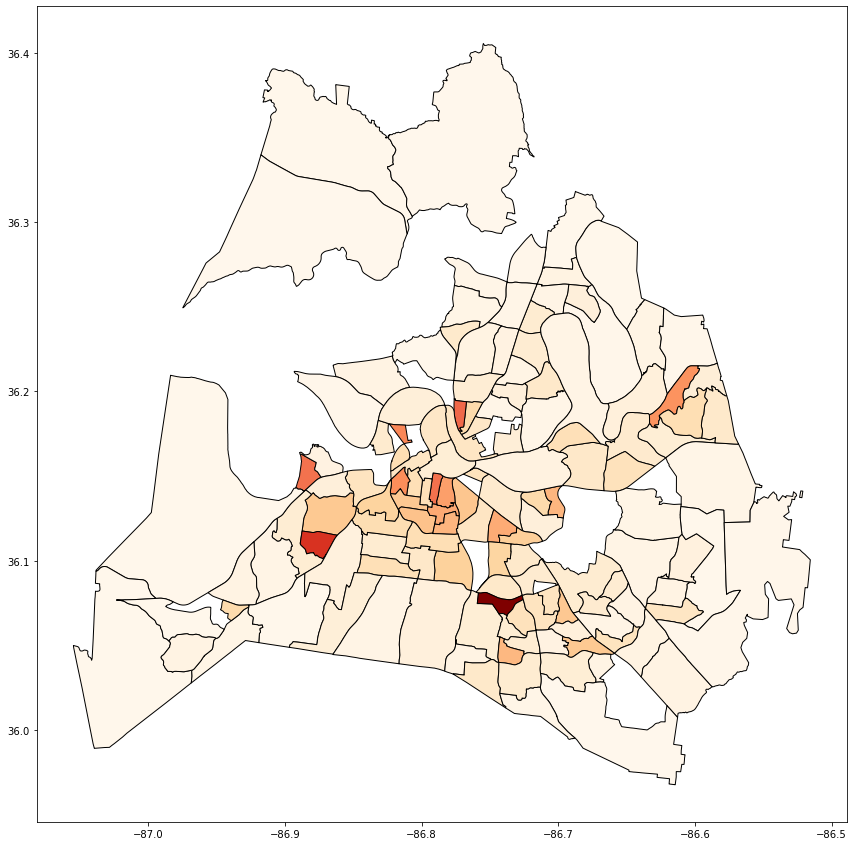

In [344]:
d_inc_mappable_df = prepare_to_map_df(d_incidents_tracts_gpd)
d_inc_mappable_df.plot(figsize=(15, 15), cmap='OrRd', column='incidents_per_sqft_per_pop', edgecolor='black')


In [325]:
##Convert to DateTime in order to assign a Time_Window
##Windows for Tornado are 12pm to 5am - Windows for Derecho are 4pm to 1230pm next day - each has 5
t911_zips_gpd['DateTime'] = pd.to_datetime(t911_zips_gpd['Seizure DateTime'])

t911_zips_gpd.loc[t911_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 00:00:00'), pd.Timestamp('2020-03-03 01:00:00')), 'Time_Window'] = 1
t911_zips_gpd.loc[t911_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 01:00:00'), pd.Timestamp('2020-03-03 02:00:00')), 'Time_Window'] = 2
t911_zips_gpd.loc[t911_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 02:00:00'), pd.Timestamp('2020-03-03 03:00:00')), 'Time_Window'] = 3
t911_zips_gpd.loc[t911_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 03:00:00'), pd.Timestamp('2020-03-03 04:00:00')), 'Time_Window'] = 4
t911_zips_gpd.loc[t911_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 04:00:00'), pd.Timestamp('2020-03-03 05:00:00')), 'Time_Window'] = 5

In [326]:
d911_zips_gpd['DateTime'] = pd.to_datetime(d911_zips_gpd['Seizure DateTime'])

d911_zips_gpd.loc[d911_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 16:00:00'), pd.Timestamp('2020-05-03 17:30:00')), 'Time_Window'] = 1
d911_zips_gpd.loc[d911_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 17:30:00'), pd.Timestamp('2020-05-03 19:00:00')), 'Time_Window'] = 2
d911_zips_gpd.loc[d911_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 19:00:00'), pd.Timestamp('2020-05-03 20:30:00')), 'Time_Window'] = 3
d911_zips_gpd.loc[d911_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 20:30:00'), pd.Timestamp('2020-05-03 22:00:00')), 'Time_Window'] = 4
d911_zips_gpd.loc[d911_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 22:00:00'), pd.Timestamp('2020-05-04 22:00:00')), 'Time_Window'] = 5


In [327]:
tincidents_zips_gpd['DateTime'] = pd.to_datetime(tincidents_zips_gpd['IncidentDate'])

tincidents_zips_gpd.loc[tincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 00:00:00'), pd.Timestamp('2020-03-03 01:00:00')), 'Time_Window'] = 1
tincidents_zips_gpd.loc[tincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 01:00:00'), pd.Timestamp('2020-03-03 02:00:00')), 'Time_Window'] = 2
tincidents_zips_gpd.loc[tincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 02:00:00'), pd.Timestamp('2020-03-03 03:00:00')), 'Time_Window'] = 3
tincidents_zips_gpd.loc[tincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 03:00:00'), pd.Timestamp('2020-03-03 04:00:00')), 'Time_Window'] = 4
tincidents_zips_gpd.loc[tincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-03-03 04:00:00'), pd.Timestamp('2020-03-03 05:00:00')), 'Time_Window'] = 5


In [328]:
dincidents_zips_gpd['DateTime'] = pd.to_datetime(dincidents_zips_gpd['IncidentDate'])

dincidents_zips_gpd.loc[dincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 16:00:00'), pd.Timestamp('2020-05-03 17:30:00')), 'Time_Window'] = 1
dincidents_zips_gpd.loc[dincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 17:30:00'), pd.Timestamp('2020-05-03 19:00:00')), 'Time_Window'] = 2
dincidents_zips_gpd.loc[dincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 19:00:00'), pd.Timestamp('2020-05-03 20:30:00')), 'Time_Window'] = 3
dincidents_zips_gpd.loc[dincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 20:30:00'), pd.Timestamp('2020-05-03 22:00:00')), 'Time_Window'] = 4
dincidents_zips_gpd.loc[dincidents_zips_gpd['DateTime'].between(pd.Timestamp('2020-05-03 22:00:00'), pd.Timestamp('2020-05-04 22:00:00')), 'Time_Window'] = 5


In [329]:
derech_map = folium.Map(location=[36.16, -86.72], zoom_start=11)
##This is an arbitrary location within Nashville to start; this could be more centered
folium.TileLayer('stamentoner').add_to(derech_map)
step = cm.StepColormap(
    ['#5d4eff', '#52a4ff', '#00f9ff', '#50ff7f', '#44ff32'],
    vmin=0.0, vmax=7.5,    
    caption='Hours Since Start of Storm'    
).add_to(derech_map)

for ind, row in d911_zips_gpd.iterrows():
    color='white'
    ##From blue to green::early - late
    if row['Time_Window'] == 1:
        color='#5d4eff'
    elif row['Time_Window'] == 2:
        color='#52a4ff'
    elif row['Time_Window'] == 3:
        color='#00f9ff'
    elif row['Time_Window'] == 4:
        color='#50ff7f'
    elif row['Time_Window'] == 5:
        color='#44ff32'
    folium.Circle(location=row['latlong'], color=color, opacity=0.7, radius=150).add_to(derech_map)
derech_map

In [330]:
torn_map = folium.Map(location=[36.16, -86.72], zoom_start=12)
##This is an arbitrary location within Nashville to start; this could be more centered
folium.TileLayer('stamentoner').add_to(torn_map)
step = cm.StepColormap(
    ['#ffb3b3', '#ff8080', '#ff4d4d', '#ff1a1a', '#e60000'],
    vmin=0.0, vmax=5.0,    
    caption='Hours Since Start of Storm'    
).add_to(torn_map)

for ind, row in t911_zips_gpd.iterrows():
    color='white'
    ##From light red to dark red::early - late
    if row['Time_Window'] == 1:
        color='#ffb3b3'
    elif row['Time_Window'] == 2:
        color='#ff8080'
    elif row['Time_Window'] == 3:
        color='#ff4d4d'
    elif row['Time_Window'] == 4:
        color='#ff1a1a'
    elif row['Time_Window'] == 5:
        color='#e60000'
    folium.Circle(location=row['latlong'], color=color, radius=80).add_to(torn_map)
torn_map

In [331]:
derech_inc_map = folium.Map(location=[36.16, -86.72], zoom_start=11)
##This is an arbitrary location within Nashville to start; this could be more centered
folium.TileLayer('stamentoner').add_to(derech_inc_map)
step = cm.StepColormap(
    ['#5d4eff', '#52a4ff', '#00f9ff', '#50ff7f', '#44ff32'],
    vmin=0.0, vmax=7.5,    
    caption='Hours Since Start of Storm'    
).add_to(derech_inc_map)

for ind, row in dincidents_zips_gpd.iterrows():
    color='white'
    if row['Time_Window'] == 1:
        color='#5d4eff'
    elif row['Time_Window'] == 2:
        color='#52a4ff'
    elif row['Time_Window'] == 3:
        color='#00f9ff'
    elif row['Time_Window'] == 4:
        color='#50ff7f'
    elif row['Time_Window'] == 5:
        color='#44ff32'
    folium.Circle(location=row['latlong'], color=color, radius=80, tooltip=dincidents_gpd.loc[ind,'IncidentTypeDescription1']).add_to(derech_inc_map)
derech_inc_map

In [332]:
torn_inc_map = folium.Map(location=[36.16, -86.72], zoom_start=11)
##This is an arbitrary location within Nashville to start; this could be more centered
folium.TileLayer('stamentoner').add_to(torn_inc_map)
step = cm.StepColormap(
    ['#ffb3b3', '#ff8080', '#ff4d4d', '#ff1a1a', '#e60000'],
    vmin=0.0, vmax=5.0,    
    caption='Hours Since Start of Storm'    
).add_to(torn_inc_map)
for ind, row in tincidents_zips_gpd.iterrows():
    color='white'
    if row['Time_Window'] == 1:
        color='#ffb3b3'
    elif row['Time_Window'] == 2:
        color='#ff8080'
    elif row['Time_Window'] == 3:
        color='#ff4d4d'
    elif row['Time_Window'] == 4:
        color='#ff1a1a'
    elif row['Time_Window'] == 5:
        color='#e60000'
    folium.Circle(location=row['latlong'], color=color, radius=80, tooltip=tincidents_gpd.loc[ind,'IncidentTypeDescription1']).add_to(torn_inc_map)
torn_inc_map

In [113]:
##startd = '2020-03-03 00:00:00'
##endd = '2020-03-03 05:00:00'

##start = time.mktime(datetime.datetime.strptime(startd, "%Y-%m-%d %H:%M:%S").timetuple())
##end = time.mktime(datetime.datetime.strptime(endd, "%Y-%m-%d %H:%M:%S").timetuple())